To this end, we will be using the Sentiment140 dataset containing data collected from twitter.

# 1. Importing and Discovering the dataset

In [1]:
from time import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Reading the dataset with no columns titles with lation encoding 
df_raw = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding= "ISO-8859-1", header = None)

df_raw.columns = ["Labels", "Time" , "date", "query", "Username" , "text"]

df_raw.head(10) # show first 10 rows of this dataset

,Labels,Time,date,query,Username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [3]:
# Checking the data's output balance
# the label '4' denotes positive and '0' denotes negative sentiment
df_raw['Labels'].value_counts()

4    800000
0    800000
Name: Labels, dtype: int64

In [4]:
#Ommiting every column except for the text and label. as we won't need any of the other information 
df = df_raw[["Labels",'text']]
df.head()

,Labels,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


As our data is huge(16,00,000 rows), working with it on a regular machine is very challenging.For this reason, we will trim our dataframe to 1/4th of its orginal size.
As data output balance is key for a better performing algorithm, we will make sure to maintain the data balance while trimming the dataframe.

In [5]:
# Separating positive and negative rows
df_pos = df[df["Labels"] == 4]
df_neg = df[df["Labels"] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [6]:
#Only retaining 1/4th of our data from each output group
df_pos = df_pos[:int(len(df_pos)/4)]
df_neg = df_neg[:int(len(df_neg)/4)]
print(len(df_pos), len(df_neg))

200000 200000


In [7]:
#concatinating both positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos , df_neg])
len(df)

400000

# 2. Cleaning and Processing the data

### 2.1 Tokenization

In order to feed our text data to a classification model, we first need to tokenize it.
Tokenizer is the process of splitting a single of text into a list of individual words, or tokens.

over here we will use TweetTokenizer; a Twitter-aware tokenizer provided by the nltk library.

In [8]:
start_time = time()
from nltk.tokenize import TweetTokenizer
#the reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest.
#for example, it will transform the word: 'Helooooooooo' to: 'Helooo'
tk = TweetTokenizer(reduce_len=True)
data = []

#separating our features (text) and our labels into two lists to smoothen our work.
X= df['text'].tolist()
Y= df['Labels'].tolist()

#Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
#and its corresponding label
for X, Y in zip(X,Y):
    if Y== 4:
        data.append((tk.tokenize(X) , 1))
        
    else:
        data.append((tk.tokenize(X),0))

#printing the CPU time and the first 5 elements of our 'data' list

print('CPU Time', time() - start_time)

print(data[:5])
        

CPU Time 82.15773582458496
[(['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!'], 1), (['im', 'meeting', 'up', 'with', 'one', 'of', 'my', 'besties', 'tonight', '!', 'Cant', 'wait', '!', '!', '-', 'GIRL', 'TALK', '!', '!'], 1), (['@DaRealSunisaKim', 'Thanks', 'for', 'the', 'Twitter', 'add', ',', 'Sunisa', '!', 'I', 'got', 'to', 'meet', 'you', 'once', 'at', 'a', 'HIN', 'show', 'here', 'in', 'the', 'DC', 'area', 'and', 'you', 'were', 'a', 'sweetheart', '.'], 1), (['Being', 'sick', 'can', 'be', 'really', 'cheap', 'when', 'it', 'hurts', 'too', 'much', 'to', 'eat', 'real', 'food', 'Plus', ',', 'your', 'friends', 'make', 'you', 'soup'], 1), (['@LovesBrooklyn2', 'he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]


# 2.2 Lemmatization
### Acoording to the Cambridge English Dictionary, Lemmatization is the process of reducing the different forms of a word to one single form, for example reducing "builds" , "building" or "built" to the lemma "build". This will greatly help our classifier by treating all variants of a given word as being references to the original lemma word.
### In this example, we will use nltk's WordNetLemmatizer to accomplish this task. This lemmatizer however takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding part of speech. The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize nltk's post_tag function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag. Various position tags can be outputted from the pos_tag function, however the most notable ones are:

    NNP: Noun, proper, singular
    NN: Noun, common, singular or mass.
    VBG: Verb, gerund or present participle.
    VBN: Verb, past participle.

A full list of position tags can be found at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [9]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')
# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\soura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('LOVE', 'VBP'), ('@Health4UandPets', 'NNS'), ('u', 'JJ'), ('guys', 'NNS'), ('r', 'VBP'), ('the', 'DT'), ('best', 'JJS'), ('!', '.'), ('!', '.')]


In [10]:
nltk.download('wordnet')
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word , tag in pos_tag(tokens):
        #First , we will convert the pos_tag output tags to tag format that the WordNetLemmatizer() can interpret
        #In general, If a tag starts with NN, the word is a noun and if it starts with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos ='a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence
    
    
#previewing the WordNetLemmatizer() output
print(data[0][0])
print(lemmatize_sentence(data[0][0]))



    

['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!']


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soura\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['I', 'LOVE', '@Health4UandPets', 'u', 'guy', 'r', 'the', 'best', '!', '!']


# Cleaning the Data

In [11]:
import re , string
nltk.download('stopwords')
#Stopwords are frequently-used words (such as "the, "a","an","in") that do not hold any meaning useful to extract entiment.
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custome function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present case would negatively impact the performance.
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return "are"
    if token == 'some1':
        return "someone"
    if token == 'yrs':
        return 'years'
    if token == "mins":
        return "minutes"
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token =='2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forgot'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25' :
        return ' '
    return token


#This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):
    cleaned_tokens = []
    for token , tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        #Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","",token)
        
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        
        cleaned_token = cleaned(token.lower())
        
        #Eliminating the token if its length is less than 3 , if it is a punctuation or if it is a stopword
        
        if cleaned_token not in string.punctuation and len(cleaned_token)>2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

#previewing the remove_noise() output
print(data[0][0])
print(remove_noise(data[0][0]))           
        

['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!']
['love', 'guy', 'best']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
start_time = time()
# As the naive Bayesian classifier accepts inputs in a dict-like structure,
#we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token , True] for token in cleaned_tokens)

cleaned_tokens_list = []

#Removing noise from all the data
for tokens , label in data:
    cleaned_tokens_list.append((remove_noise(tokens),label))

print("Removed Noise, Cpu Time:", time()-start_time)
start_time = time()

final_data = []

#Transforming the data to fit the input stucture of the Naive Baysian classifier
for tokens , label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens),label))
print("Data prepared for model , CPU time:", time()-start_time)

final_data[:5]
    

Removed Noise, Cpu Time: 1097.1268634796143
Data prepared for model , CPU time: 2.4622647762298584


[({'love': True, 'guy': True, 'best': True}, 1),
 ({'meet': True,
   'one': True,
   'besties': True,
   'tonight': True,
   'cant': True,
   'wait': True,
   'girl': True,
   'talk': True},
  1),
 ({'thanks': True,
   'twitter': True,
   'add': True,
   'sunisa': True,
   'get': True,
   'meet': True,
   'hin': True,
   'show': True,
   'area': True,
   'sweetheart': True},
  1),
 ({'sick': True,
   'really': True,
   'cheap': True,
   'hurt': True,
   'much': True,
   'eat': True,
   'real': True,
   'food': True,
   'plus': True,
   'friend': True,
   'make': True,
   'soup': True},
  1),
 ({'effect': True, 'everyone': True}, 1)]

# 3. Visualizing the Data

WordClouds are one of the best visualizations for words frequencies in text documents.
Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

positive words


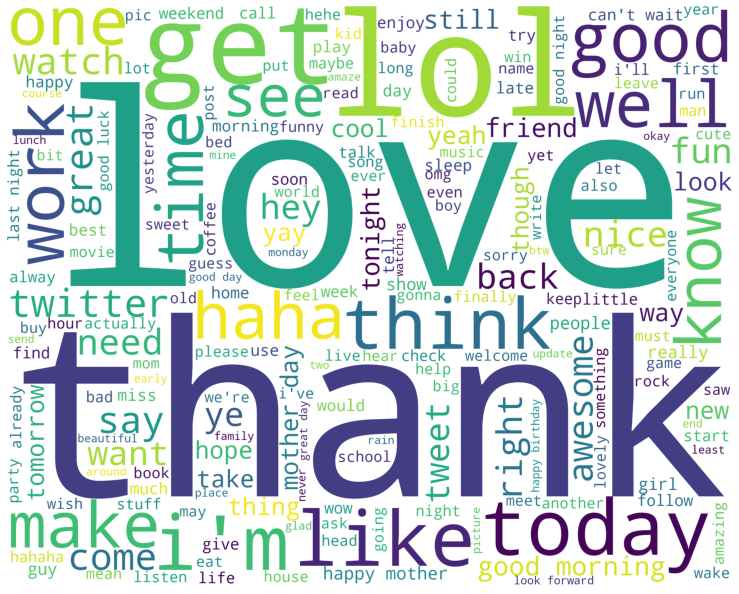

negative words


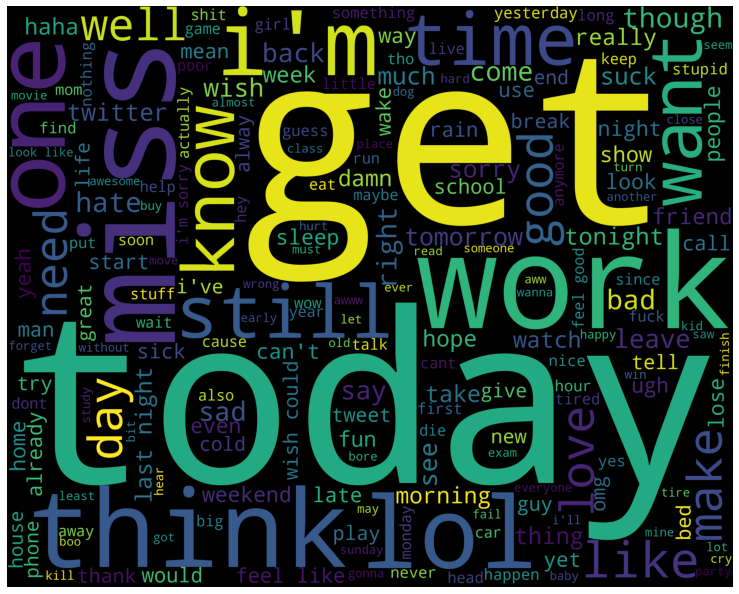

In [13]:
!pip install wordcloud
from wordcloud import WordCloud , STOPWORDS

start_time = time()

positive_words =[]
negative_words =[]

#separating out positive and negative words (i.e., words appearing in negative and positive tweets)
#in order to visualize each set of words independently

for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])
        
#Defining our word cloud drawing function
def word_cloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOP_WORDS,
                         background_color = color,
                         width = 2500,
                         height = 2000).generate(' '.join(data))
    plt.figure(1, figsize= (13,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("positive words")
word_cloud_draw(positive_words, 'white')
print("negative words")
word_cloud_draw(negative_words , "black")

Those words clouds are beautiful 
it's quite interesting to observe the (higher) occurence of |"love"| , |"lol"| and |"thank"| in thr positive tweets, and of |"work"| and |"miss"| in the negative tweets. However, and in my opinion, the most compelling information observed in those images is without a doubt the huge occurence of the word today in the negative

I personally interpret this information as follows: Bad news travel faster than good news. Peaple tend to talk and share bad news mush more frequently and much more quickly than good news.

# Naive Bayesian Model 

Now that our data is somewhat clean, we can use it to build our classification model. One of the most commonly used classification models in Natural Language Processing (NLP) is Naive Bayesian.
Naive Bayesian classifier are a collecetion of classification algorithm based on Bayes' Theorem.it is not a single algorithm but rather a family of algorithms where all of them make the following naive assumptions:

    All features are independent from each other.
    Every feature contributes equally to the output.

In our case, these two assumption can be interpreted as:

    Each word is independent from the other words, no relation between any two words of a given sentence.
    Each word contributes equally, throughout all sentences, to the decision of our model, regardless of its    relative position in the sentence.
Example: "This is bad" / "This is very bad" or "Such a kind person" / "This kind of chocolate is disgusting" , in both cases the Naive Bayesian classifier would give the same importance for the words 'bad' and 'kind', albeit them having a stronger meaning and different meaning respectively in first and second sentences.

nevertheless, Naive Bayesian are widely used in NLP and they often outpur great results.

The Bayes' Theorem describes the probabily of an event A, based on prior knowlwdge of conditions B that might be related to the event: P(A∣B)=P(B∣A)P(A)/P(B).
In our case, this can be intuitively interpreted as the probability of a tweet being positive, based on prior knowledge of the words inside the input text. In a nutshell, this probability is the probability of the first word occuring in a positibve tweet, times, the probability of second word occuring in a positive tweet,...., time, the probability of a tweet being positive. this can be mathematically written as:
P(A∣B)∝P(B1∣A)×P(B2∣A)×⋅⋅⋅×P(Bn∣A)×P(A)
More details can be found at: https://www.geeksforgeeks.org/naive-bayes-classifiers/


# Splitting the data

First, we need to split our data into two sets: Training and Testing sets.
1. Train Data is data used in order to build and train our classification model.
2. Test Data is data, that our classifier model has never seen before, used in order to assert the accuracy and test our classification model.

In [14]:
#as our data is currently ordered by label, we have to shuffle it before splitting it.
#.Random(140) randomizes our data with seed =140. This guarantees the same suffling for every execution of our code.
# Feel free to alter this value or even omit it to have different outputs for each code execution 
random.Random(140).shuffle(final_data)
#Here we decided to split our data as 90% train data and 10% test data
#Once again, feel free to alter this number and test the model accuracy
trim_index = int(len(final_data)* 0.9)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

# 4.2. Training the model

Now it's time to train our model on our training data.
in this notebook, we will utilize nltk's NaiveBayesClassifier.

In [15]:
start_time = time()

from nltk import classify
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_data)

#output the model accuracy on the train and test data 

print('Accuracy on the train data:', classify.accuracy(classifier, train_data))
print('Accuracy on the test data:', classify.accuracy(classifier, test_data))

#output the words that provide the most information about the sentiment of a tweet.
# These are words that are heavily present in one sentiment group and very rarely present in the other group
print(classifier.show_most_informative_features(20))
print('\n CPU Time,', time() - start_time)

Accuracy on the train data: 0.8106944444444445
Accuracy on the test data: 0.755575
Most Informative Features
               depressed = True                0 : 1      =     49.0 : 1.0
               toothache = True                0 : 1      =     45.0 : 1.0
                    roni = True                0 : 1      =     34.3 : 1.0
                 unhappy = True                0 : 1      =     31.4 : 1.0
                   strep = True                0 : 1      =     31.0 : 1.0
                  asthma = True                0 : 1      =     26.3 : 1.0
                 unloved = True                0 : 1      =     25.0 : 1.0
                  #movie = True                1 : 0      =     23.0 : 1.0
                  gutted = True                0 : 1      =     22.3 : 1.0
                   hates = True                0 : 1      =     21.9 : 1.0
               heartburn = True                0 : 1      =     21.7 : 1.0
                     bom = True                1 : 0      =     21

wow, a 75.5% accuracy on the test set training a very Naive( :) ) algorithm and in just 34 seconds!

Taking a look at 20 most informative fetures of the model, we can notice the high valume of negative to positive (0:1) informative features. This is very interesting as it means that negative tweets have a much more concentreted and limited vocabulary when compared to positive tweets.



In [16]:
custom_tweet = " I ordered just once from TerribleCo they acrewed up, never used the app again"
print(tk.tokenize(custom_tweet))
custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(custom_tokens)
print(classifier.classify(dict([token,True] for token in custom_tokens)))


['I', 'ordered', 'just', 'once', 'from', 'TerribleCo', 'they', 'acrewed', 'up', ',', 'never', 'used', 'the', 'app', 'again']
['order', 'terribleco', 'acrewed', 'never', 'use', 'app']
0


In [17]:
custom_tweet = "I loved the show today! It was amazing"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [18]:
custom_tweet = "No idea"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


Nevertheless, this model has various shortcomings.
As the model only evaluates sentences at an independent word level, it performs very poorly when it comes to negations and other multi-words constructs. For example, is the model gets the following input: The concert was good ! it would simply take each individual word (Here, and after cleaning the input, |"concert"| and |"good"|) and calculate each word's probability to be either positive and negative and finally multiply everything together. Thus , we would expect the model to perform poorly on example such : The concert was not good! or i'm not very happy ;(

In [19]:
custom_tweet = 'good'
custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [20]:
custom_tweet = 'Not good'
custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


Also, the model isn't robust against sarcastic sentences.

In [21]:
custom_tweet = "The reword for good work is more work !"
custom_tokens = remove_noise(tk.tokenize(custom_tweet))
print(classifier.classify(dict([token, True] for token in custom_tokens)))

1




Finally, it is worth mentioning one more weakness of such a model: it does not generalize well.

The model would perform greatly on data similar to the data it trained on. For example, if the model learned that I love football and I love cooking carry a positive sentiment, it would be pretty easy for it to classify I love machine learning as a sentence carrying a positive sentiment. However, if the model were to classify I adore embeddings, it would most probably miss-classify it. As it never encountered any of these words before, therefore it is unable to properly classify it, and would simply output a random choice.


# 4.4 Asserting the Model
Finally, Let's further assert our model by plotting AUC and the confusion matrix of the model

In [22]:
from sklearn import metrics

#Storing all desired values in a list 
y = [test_data[i][1] for i in range(len(test_data))]
#prob = [ classifier.classify(test_data[i][0]) for i in range(len(test_data))]
prob = [classifier.prob_classify(test_data[i][0]).prob(1) for i in range(len(test_data))]
#print(prob)
print(len(y),len(prob))

#performing the roc curve calculation
fpr, tpr , thresholds = metrics.roc_curve(y,prob)

#printing the area under Curve (AUC) of the ROC curve (the closer to 1, the better)
auc = metrics.roc_auc_score(y,prob)
print('AUC: %.3f' %auc)

40000 40000
AUC: 0.834


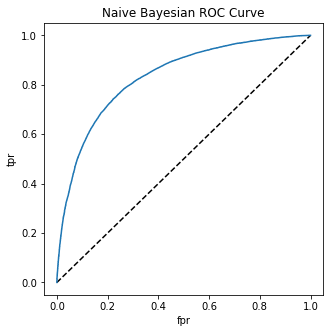

In [23]:
# Plotting the ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0,1] , [0,1] , 'k--')
plt.plot(fpr , tpr, label = 'NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Naive Bayesian ROC Curve')
plt.show()

In [24]:
# Creating a confusion matrix (this spacific confusion matrix function accepts numpy arrays rather than python lists)

probs = [classifier.classify(test_data[i][0]) for i in range(len(test_data))]
y = np.asarray(y)
probs = np.asarray(probs)
pd.crosstab(y, probs , rownames= [ 'Actual'], colnames = ['Predicted'],margins =True)

Predicted,0,1,All
Actual,,,
0,16529,3451,19980
1,6326,13694,20020
All,22855,17145,40000


# 5. Deep Learning Model - LSTM
Deep learning is a very rapidly growing field, that is proving to extremely beneficial in various scenarios. One of those scenarios, which we will bw studying in this notebook, is the ability to process text data in a much more complex and powerful manner. in fact in the next section of the notebook we will be focusing on the implementing a Deep Learning model that will tackle and solve the above mentioned shartcoming between words in a sentence and the poor generalization on previously unseen data.

A Long Short-Term Memory, or LSTM, is a type of machine learning neural network. Moren specifically, it belongs to the family of Recurrent Neural Networks (RNN) in Deep Learning, whhich are specifically conceived in order to process temporal data. Temporal data is defined as data that is highly influenced by order that it is presented in. This means that data coming before or after a given datum(singular for data) can greatly affect this datum. text data is an example of temporal data. for example, lets consider the followig sentence:

    Jane is not very happy. she's still mad at you!
    
In the above sentence, the word not greatly influences the mening of the upcoming words very happy. Also, we used the word she as we are speaking about a female subject. 
Also, here's a fun example conveying the influence of words positions directly influencing a sentences meaning :
    
    Are you clever as i am?
    Am i as clever as you are?
  
    
 
   

# Data Pre-processing

In order to feed our text data to our LSTM model, we'll have to go through several extra preprocessing steps.

Most neural networks expect number as input. Thus, we'll have to convert our text data to numerical data.

one way of doing so would be following: collect all possible words in our dataset and generate a dictionary containing all unique words in our text corpus, then sort all of these words alphabetically and assign to each  word as index. So for example, let's say our dictionary's length tuned out to be 100,00 words. The word "a" would be assigned the index 0, the word "aaron" would be assigned the index 1, and so on, untill we reach the last word in our dictonay, say "zulu ", and assign to it the index 00,999. Great! Now each word is represent with numerical value, and we can feed the numerical value each word ro our model.

It turns out that this step alone is not enough to be able to train good Deep learning models. If you think about it, when the model reads an  input 20,560 and then another input 20,561 for example, it would suume that these values are "close". How ever, those inputs could be the indexs of totally unrelated words, such as "cocktail" and "code" appearing right next to each other in the sorted dictionary. Hoping i've convinced you with this example, and that you hopefully believe that "cocktail" and "code" are , and sould be always be, completely unrelated, let's take a look at one solution that is widely adopted in various NLP implementetions.



Also, one simple solution for this problem is to use One-Hot vectors to represent each word, but we won't bother with One-Hot vectors in this notebook, as we will be discussing a much more robust solution.

# 5.11. Word Embedding

Word embedding are basically a way for us to convert words to representational vectors. what i mean by this is that, instead of mapping each word to an index, we want to map each word to a vector of real numbers, representing this word

The goal here is to be able to generate similar or close representational vectors for words that have similar meaning. For example, when feeding the words "excited" and "thilled" to the word embedding model, we would like model to output "close" representation for both words. Whereas if we feed the words "excited" and 'Java', we would like the model to output "far" representation for both words.

The concept of "close" and "far" vectors is actually implemented using the cosine similarity. In fact, word embeddings and distance between words or relation between words is an immense discussion in its own. So I'll just keep my explanation to a minimum in this notebook.





In [25]:
# Downloading and unzipping the glove word embedding from the official website
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
# Defining a handy function in order to load glove file
def read_glove_vecs(glove_file):
    with open(glove_file, 'r' ,encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype = np.float64)
            
        i=1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i]=w
            i= i+1
    return words_to_index , index_to_words , word_to_vec_map 
        
                
            
words_to_index, index_to_words , word_to_vec_map = read_glove_vecs("glove.6B.50d.txt")




As this word embedding only considers 400,000 unique words, it might encounter words it has never seen before. For example, the word "LSTM" is most likely not included in those 400,000 words.

In order to overcome such scenarios, word embeddings reserve an extra spot for "unknown" words, also denoted with the keyword unk.


In [27]:
words_to_index['unk']

372306

Below is a short example of the usage of the cosine similarity in order to find correlations in the data.

we can observe that the words cucumber and tometo are highly positively similar. Whereas the words cucumber and phone are not related at all, having a close to 0 similarity measure.

    Note that the Cosine similarity return values between -1 and +1, where -1 denote completely opposite meaning, +1 denote completely identical meanings and 0 denote totally unrelated meaning

In [28]:
def cosine_similarity(u,v):
    dot = np.dot(u,v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

In [29]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map["tomato"])

0.8632714714841137

In [30]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['phone'])

-0.01248550672123597

# 5.1.3 Data Padding

Further in our training we would like to speed the process up by splitting data into mini-batches. Batch learning is basically the process of training on several examples at the same time, which greatly decreases the training time!

However, and in order to be able to utilize batch learning, keras(and similarly to most machine learning frameworks) requres all data within the same batch to have the same length or dimension.
whereas in our text data,each example could have a variable sentence length. In order to overcome this issue, we will go over all of our data, and calculate the length of the longest phrase (in terms of words). Then, we will 0-pad all of the data sequences so that they will all have the same max_len calculated.

In [31]:
start_time = time()
unks = []
UNKS = []
#This function will act as a "last resort" in order to try and find the word
#in the words embedding layer. it will basically eliminate contigiously occuring
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res
def sentence_to_indices(sentence_words, word_to_index, max_len , i):
    global X,Y
    sentence_indices = []
    for j ,w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w= cleared(w)
            try:
                index = word_to_index[w]
            except:
                index= word_to_index['unk']
                unks.append(w)
        X[i,j] = index
    # Here we will utilize the already computed "cleaned_tokens_list" variable
print('Removed Noise, CPU Time:', time() - start_time)

list_len = [len(i) for i,j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list),max_len))
Y = np.zeros((len(cleaned_tokens_list),1))

for i , tk_lb in enumerate(cleaned_tokens_list):
    tokens, labels = tk_lb
    sentence_to_indices(tokens, words_to_index , max_len , i)
    Y[i] = labels
print('Data prepared for model, CPU Time:', time() - start_time)

print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 0.0
max_len: 25
Data prepared for model, CPU Time: 3.8323981761932373
[[226278. 169725.  74390.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [239785. 269953. 372306. 361859.  91041. 382320. 161844. 352214.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [357161. 368306.  46173. 372306. 160418. 239785. 179025. 329974.  58999.
  349437.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [330826. 302352.  97698. 184322. 251645. 132701. 302292. 151204. 286963.
  154049. 231458. 338210.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [133896. 141948.      0.      0.      0.      0.      0.      0.      0.
   

In [32]:
cleaned_tokens_list[5]

(['tell',
  'burst',
  'laugh',
  'really',
  'loud',
  'thanks',
  'make',
  'come',
  'sulk'],
 1)

In [33]:
# 5.3 Building the Model 

In [34]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout , LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

In [35]:
#Defining a function that will initialize and populated our embedding layer
def pretrained_embedding_layer(word_to_vec_map , word_to_index,max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map['unk'].shape[0]
    emb_matrix = np.zeros((vocab_len , emb_dim))
    
    for word , idx in word_to_index.items():
        emb_matrix[idx, : ] = word_to_vec_map[word]
    embedding_layer =  Embedding(vocab_len , emb_dim ,trainable = False , input_shape=(max_len,))
    embedding_layer.build((None, ))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [36]:
#Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional lSTMs,
#that finally feed into a sigmoid layer that generates our desired output between 0 and 1
model = Sequential()
model.add(pretrained_embedding_layer(word_to_vec_map, words_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences = True)))
model.add(Bidirectional(LSTM(units=128, return_sequences = False)))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [37]:
#compiling our model with a binary cross-entropy loss function, using the default adam optimizer 
#and setting the accuracy as the metric to track
model.compile(loss= 'binary_crossentropy' , optimizer ='adam', metrics = ['accuracy'])

In [38]:
X_train , X_test , Y_train , Y_test = train_test_split(X,Y , test_size = 0.2 , random_state = 0 , stratify=Y)

In [39]:
len(X_train)

320000

In [40]:
len(X_test)

80000

# 5.4. Train the model

In [41]:
# Setting a batch size of 20 and training our model for 20 epochs
model.fit(X_train,Y_train , validation_data=(X_test,Y_test) , epochs =20, batch_size= 128, shuffle =True)

Epoch 1/20
2500/2500 [==============================] - 705s 278ms/step - loss: 0.5808 - accuracy: 0.6890 - val_loss: 0.5183 - val_accuracy: 0.7419
Epoch 2/20
2500/2500 [==============================] - 687s 275ms/step - loss: 0.5123 - accuracy: 0.7436 - val_loss: 0.4976 - val_accuracy: 0.7531
Epoch 3/20
2500/2500 [==============================] - 685s 274ms/step - loss: 0.4866 - accuracy: 0.7598 - val_loss: 0.4886 - val_accuracy: 0.7599
Epoch 4/20
2500/2500 [==============================] - 633s 253ms/step - loss: 0.4683 - accuracy: 0.7733 - val_loss: 0.4866 - val_accuracy: 0.7619
Epoch 5/20
2500/2500 [==============================] - 680s 272ms/step - loss: 0.4482 - accuracy: 0.7860 - val_loss: 0.4816 - val_accuracy: 0.7658
Epoch 6/20
2500/2500 [==============================] - 739s 296ms/step - loss: 0.4272 - accuracy: 0.7971 - val_loss: 0.4915 - val_accuracy: 0.7633
Epoch 7/20
2500/2500 [==============================] - 712s 285ms/step - loss: 0.3362 - accuracy: 0.8473 - val_

In [42]:
#plot_acc_lossning a handy function in order to plot various models accuracy and loss progress
def plot_acc_loss(history):
    
    acc= history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) +1)
    
    plt.plot(epochs , acc , label = "Training acc")
    plt.plot(epochs, val_acc , label = "validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs , loss , label = "Training Loss")
    plt.plot(epochs , val_loss , label = "validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

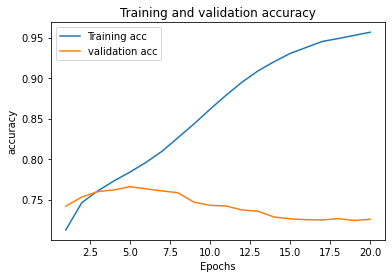

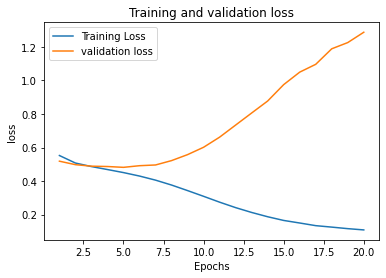

In [43]:
plot_acc_loss(model.history)

The Training accuracy is sky-rocking, exceeding 95% after 20 epochs! However, the validation accuracy increase slightly in the early epochs, reaching 76.7% on the 5th epoch, after which it experienced a consistently gradual decrease. In data science, we would classify the model as having very high variance and low bias This is also referred to as "over-fitting"

over-Fitting is basically the phenomenon where the model's performance on validation data strats degrading, while still achieving great progress on the test set. In other words, the model is doing exceptionally well on learning specific examples it has been trained on, but is falling to generalize to data it never saw its training phase

# 5.5 Investigating possibilities to improve the Model

Several direction could be undertaken at this stage in order to improve our model's performance. Arguably, the most promising direction to firstly look into is to introduce some kind of regularzition in our model in order to try to reduce the clearly apparent over-fitting problem our model is facing. Let's specifically look at the dropout regularization technique

# 5.5.1 Regularization - Dropout

Regularization is the process of preventing a model from over-fitting the training data. You can conceptualize regularization as being a tool we use in order to render our model less sensible to every detail, and possibly outliers, in the training data This should allow the model to better generalize and have a better performance on the validation data, or any data it wasn't trained on.

Dropout is one of the many regularization techniques, and also one of the simplest to implement and most commonly used. Bassically, what dropout does is that it randomly eliminates several (based on a parametrized percentage rate) neurons connections in the network, rendering themodel less complex, and forcing the model to only look at part of given example. The random elimination of connections in the model is repeated randomly for each example training data.


For example, let's consider the following sentences, with a dropout layer with a rate of 0.5 (50% of connections will be eliminated)


    "Another kind of regularization can be directly applied to the cost function"
    
    "This is my first ever notebook. Hope you're enjoying it so far"
    
The output of the dropout layer could look like the following:
    
    "Kind of regularization be to function"
    
    "This my notebook. you enjoying it far"

Thus, The model will only have information on a part of the input example, and should be able to escape over-fitting particular characteristics of the training data

In [44]:
keras.backend.clear_session()
model_dropout = Sequential()
model_dropout.add(pretrained_embedding_layer(word_to_vec_map,words_to_index,max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences= True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences= False)))
model_dropout.add(Dense(units=1, activation = 'sigmoid'))
model_dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            20000050  
_________________________________________________________________
dropout (Dropout)            (None, 25, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           183296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
______________________________________

In [45]:
model_dropout.compile(loss='binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])


In [46]:
model_dropout.fit(X_train,Y_train ,validation_data = (X_test, Y_test), epochs = 20 , batch_size = 128 , shuffle = True)

Epoch 1/20
2500/2500 [==============================] - 809s 317ms/step - loss: 0.6164 - accuracy: 0.6533 - val_loss: 0.5479 - val_accuracy: 0.7203
Epoch 2/20
2500/2500 [==============================] - 773s 309ms/step - loss: 0.5669 - accuracy: 0.7001 - val_loss: 0.5199 - val_accuracy: 0.7385
Epoch 3/20
2500/2500 [==============================] - 767s 307ms/step - loss: 0.5512 - accuracy: 0.7121 - val_loss: 0.5089 - val_accuracy: 0.7463
Epoch 4/20
2500/2500 [==============================] - 775s 310ms/step - loss: 0.5432 - accuracy: 0.7192 - val_loss: 0.5028 - val_accuracy: 0.7505
Epoch 5/20
2500/2500 [==============================] - 772s 309ms/step - loss: 0.5341 - accuracy: 0.7258 - val_loss: 0.4981 - val_accuracy: 0.7525
Epoch 6/20
2500/2500 [==============================] - 847s 339ms/step - loss: 0.5280 - accuracy: 0.7302 - val_loss: 0.4928 - val_accuracy: 0.7566
Epoch 7/20
2500/2500 [==============================] - 848s 339ms/step - loss: 0.5237 - accuracy: 0.7326 - val_

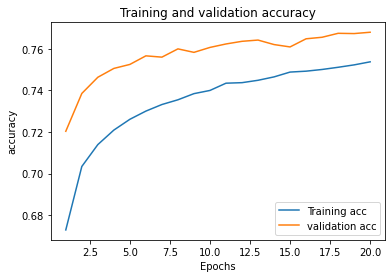

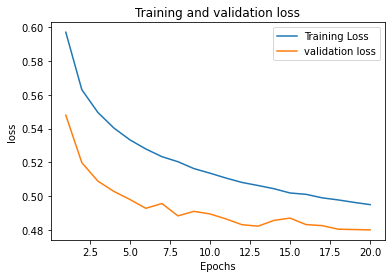

In [47]:
plot_acc_loss(model_dropout.history)

We can clearly see the effects of adding dropout layer on the training progress. The training accuracy is progressing at a much slower pace than it previously did. Nevertheless, the validation accuracy is steadily increasing, reaching 76.85%
Let's keep on training the model for 20 more epochs.


In [48]:
model_dropout.fit(X_train, Y_train , validation_data=(X_test , Y_test), epochs = 20, batch_size = 128 , shuffle = True)

Epoch 1/20
2500/2500 [==============================] - 742s 297ms/step - loss: 0.4948 - accuracy: 0.7534 - val_loss: 0.4808 - val_accuracy: 0.7671
Epoch 2/20
2500/2500 [==============================] - 747s 299ms/step - loss: 0.4928 - accuracy: 0.7547 - val_loss: 0.4812 - val_accuracy: 0.7673
Epoch 3/20
2500/2500 [==============================] - 757s 303ms/step - loss: 0.4914 - accuracy: 0.7550 - val_loss: 0.4792 - val_accuracy: 0.7679
Epoch 4/20
2500/2500 [==============================] - 762s 305ms/step - loss: 0.4916 - accuracy: 0.7556 - val_loss: 0.4787 - val_accuracy: 0.7690
Epoch 5/20
2500/2500 [==============================] - 768s 307ms/step - loss: 0.4897 - accuracy: 0.7570 - val_loss: 0.4818 - val_accuracy: 0.7687
Epoch 6/20
2500/2500 [==============================] - 770s 308ms/step - loss: 0.4901 - accuracy: 0.7573 - val_loss: 0.4792 - val_accuracy: 0.7692
Epoch 7/20
2500/2500 [==============================] - 771s 308ms/step - loss: 0.4893 - accuracy: 0.7574 - val_

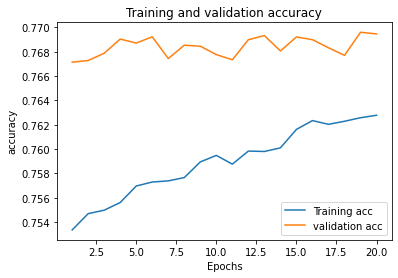

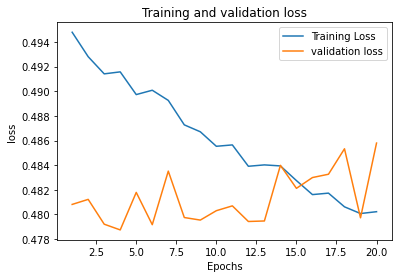

In [49]:
plot_acc_loss(model_dropout.history)

We can observe that the accuracy has plateaued, reaching its best validation value of 77.2%

Thus, we can conclude that the regularization process did not really help us in our case. A tiny 0.5% improvement was observed after adding dropout to the model.
This leads us to the second direction to investigate in order to improve our model:data



# 5.5.2 Inspecting the Data- Unknown Words
As explained earlier, Whenever a word is not included in the words embedding mapping, it is referred to as an unknown words, or unk. Let's count the number of words that are being flagged as unknown in our data.

In [50]:
unk = words_to_index['unk']
n_unk_words = 0
for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1
print(n_unk_words)

198302


200k unknown words are kind of a lot. In fact, after counting the total number of words in our data, this equates to ~7% of all words

In [51]:
len(unks)

198302

In [52]:
len(UNKS)

226476

If we remember in the above defined function sentence_to_indices , we have incorporated a "last resort" cleared, which eliminates contiguous similar caracters.It seems like our last resort of clearing the words helped us reduce the number of unknown words by 28,000 !

Let's investigate some of the most commonly occuring unknowns words in our data.

In [53]:
index_to_words[372306]

'unk'

In [54]:
from collections import Counter
Counter(unks).most_common(50)

[("i'm", 32149),
 ("can't", 11370),
 ("i'l", 6284),
 ("that's", 5478),
 ("i've", 5085),
 ("he's", 1976),
 ("mother's", 1878),
 ("i'd", 1855),
 ('hahaha', 1723),
 ("we're", 1578),
 ("there's", 1425),
 ("what's", 1356),
 ("they're", 1179),
 ('lmao', 1104),
 ("we'l", 914),
 ("let's", 802),
 ('bday', 618),
 ('. .', 600),
 ('idk', 588),
 ("it'l", 587),
 ('hahah', 486),
 ('. . .', 481),
 ("how's", 440),
 ("who's", 378),
 ('#fb', 358),
 ('hahahaha', 356),
 ("mom's", 333),
 ('#asot40', 333),
 (":'(", 327),
 ("ain't", 317),
 ("y'al", 313),
 ("we've", 312),
 ('tweps', 312),
 (';-)', 307),
 ('thanx', 290),
 ('coky', 289),
 ('#folowfriday', 266),
 ("today's", 264),
 ('hehehe', 259),
 ('awh', 259),
 ("here's", 256),
 ("where's", 239),
 ('2morow', 235),
 ('urgh', 216),
 ('ahaha', 211),
 ("he'l", 197),
 ('b-day', 193),
 ('tomorow', 191),
 ("they'l", 191),
 ("ya'l", 187)]

We can observe that most of the unknown words are very common words, However the word embeddings layer doesnot support quotes. For example, if you try to get the index of the word "i'm", you'll be prompted with a key error, whereas the word "i'm" is available as a valid key. Other words, such as "idk" , "imao" or "b-day" reminds us that our data comes from twitter, and we'll have to individually handle each of these words such that our words embedding layer recognise them.

# Further data cleaning 

Gathering insights from the above output, and from manually skimming through the data, the remove_noise function has been redefined as follows:

In [69]:
# A custom function defined in order to fine-tune the cleaning of the input text.
#This function is being "upgraded" such that it performs a more thurough cleaning of the data 
# in order to better fit our words embedding layer
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'plz' or token == 'pls':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah','hahahah', 'hahaha', 'hahahaha', 'hehehe','ahaha']:
        return 'haha'
    if token == "mother's":
        return 'mother'
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return 'dad'
    if token == "probs":
        return "problem"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't","hadn't","doesn't","won't","haven't","wasn't","weren't","hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao' , 'lolz' , 'rofl']:
        return "lol"
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp' , 'quot' , 'lt', 'gt' , '½25' , '..' , '. .','. . .']:
        return ''
    return token


#This function will be our all-in-one noise removal function 
def remove_noise(tweet_tokens):
    cleaned_tokens = []
    for token in tweet_tokens:
        #Eliminating the token if it is a link 
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        #Eliminating the token if it is a mention.
        token = re.sub("(@[A-Za-z0-9]+)","",token)
        
        cleaned_token = cleaned(token.lower())
        if cleaned_token == "it's":
            cleaned_tokens.append("it")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == 'idk':
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
            
        if cleaned_token == "he'll":
            cleaned_tokens.append('he')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "they'l":
            cleaned_tokens.append('they')
            cleaned_tokens.append('will')
            continue
        
        if cleaned_token == "i've":
            cleaned_tokens.append("i")
            cleaned_tokens.append("have")
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append("you")
            cleaned_tokens.append("have")
            continue
        if cleaned_token == "should've":
            cleaned_tokens.append("should")
            cleaned_tokens.append("have")
            continue
        if cleaned_token == "would've":
            cleaned_tokens.append("would")
            cleaned_tokens.append("have")
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append("we")
            cleaned_tokens.append("have")
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append("they")
            cleaned_tokens.append("have")
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append("you")
            cleaned_tokens.append("are")
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append("we")
            cleaned_tokens.append("are")
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append("they")
            cleaned_tokens.append("are")
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append("let")
            cleaned_tokens.append("us")
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append("she")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append("he")
            cleaned_tokens.append("is")
            continue
            
        if cleaned_token == "that's":
            cleaned_tokens.append("that")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append("i")
            cleaned_tokens.append("would")
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append("you")
            cleaned_tokens.append("would")
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append("there")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append("what")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append("how")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append("who")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "here's":
            cleaned_tokens.append("here")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "where's":
            cleaned_tokens.append("where")
            cleaned_tokens.append("is")
            continue
        if cleaned_token == "shouldnt":
            cleaned_tokens.append("should")
            cleaned_tokens.append("not")
            continue
        if cleaned_token == "they'l":
            cleaned_tokens.append("they")
            cleaned_tokens.append("will")
        if cleaned_token == "she'l":
            cleaned_tokens.append("she")
            cleaned_tokens.append("will")
        if cleaned_token == "g'night":
            cleaned_tokens.append("goodnight")
            continue
        
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append("you")
            cleaned_tokens.append("all")
            continue
        if cleaned_token.strip() and cleaned_token not in string.punctuation:
            cleaned_tokens.append(cleaned_token)
    return cleaned_tokens
 #prevewing the remove_noise() output
print(remove_noise(data[0][0]))
print(data[0][0])

['i', 'love', 'you', 'guys', 'are', 'the', 'best']
['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!']


Now let's re-compute our X and Y arrays according to the newly defined remove_noise function

In [70]:
start_time = time()
unks = []
UNKS = []

def cleared(word):
    res=''
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res
def sentence_to_indices(sentence_words, word_to_index, max_len , i):
    global X,Y
    sentence_indices = []
    for j , w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i,j] = index
        
cleaned_tokens_list = []
for tokens,label in data:
    x= remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x,label))
print("removed Noise, CPU Time", time()- start_time)
start_time = time()

list_len = [len(i) for i , j in cleaned_tokens_list]
max_len = max(list_len)
print(max_len)

X=np.zeros((len(cleaned_tokens_list),max_len))
Y= np.zeros((len(cleaned_tokens_list), ))

for i ,tk_lb in enumerate(cleaned_tokens_list):
    tokens , label = tk_lb
    sentence_to_indices(tokens,words_to_index,max_len,i)
    Y[i] = label
print('Data Prepared for model, CPU time:', time() - start_time)
print(X[:5])
print(Y[:5])


removed Noise, CPU Time 69.77964544296265
79
Data Prepared for model, CPU time: 5.331064701080322
[[185457. 226278. 394475. 169754.  58997. 357266.  74390.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [187631. 239792. 373317. 388711. 269953. 268046. 254258. 372306. 361859.
   91041. 382320. 161844. 352214.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.    

In [73]:
# let's take a look at the progress accomplished:
unk = words_to_index['unk']
n_unk_words = 0
for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1
n_unk_words

133854

In [74]:
from collections import Counter
Counter(unks).most_common(50)

[(':/', 688),
 ('(:', 451),
 ('. .', 397),
 ('#fb', 358),
 ('#asot40', 333),
 (":'(", 327),
 ('tweps', 312),
 (';-)', 307),
 ('werent', 301),
 ('->', 288),
 ('iï', 278),
 ('#folowfriday', 266),
 ("today's", 264),
 ('d:', 261),
 ('awh', 259),
 ('2morow', 235),
 ('urgh', 216),
 ('_x', 215),
 ('tomorow', 191),
 ("they'l", 191),
 ('8:', 189),
 ('sux', 184),
 ('_carter', 179),
 ('hadnt', 178),
 ('tmrw', 177),
 ('bleh', 174),
 ('retwet', 173),
 ('yey', 171),
 ('<-', 167),
 ('#delongeday', 167),
 ('theyve', 164),
 ('twiterverse', 160),
 ('awsome', 150),
 ("friend's", 148),
 ('lï', 146),
 ('itï', 142),
 ('cï', 139),
 ("everyone's", 138),
 ('twiterland', 137),
 ('damnit', 137),
 ('omfg', 136),
 ("she'l", 135),
 ('=/', 134),
 ('proly', 134),
 ('=]', 134),
 (':-d', 127),
 ('mï', 126),
 ('woho', 124),
 ("it'd", 124),
 ('nï', 119)]

Further optimizing the number of unknown words at this point would not br the best use  of our time. As now we left with a big number of minimally occuring words in the data. thus , spending more time cleaning the data would result in a very little return on investment

Now, let's try to train our model on the newly generated cleaner data!


# Model train_cleaner data

In [75]:
keras.backend.clear_session()

model_cleaner = Sequential()

model_cleaner.add(pretrained_embedding_layer(word_to_vec_map, words_to_index, max_len))
model_cleaner.add(Dropout(rate=0.4))
model_cleaner.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_cleaner.add(Dropout(rate=0.4))
model_cleaner.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_cleaner.add(Dense(units=1, activation='sigmoid'))

model_cleaner.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 79, 50)            20000050  
_________________________________________________________________
dropout (Dropout)            (None, 79, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 79, 256)           183296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
______________________________________

In [78]:
model_cleaner.compile(loss ='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [82]:
X_train , X_test , Y_train , Y_test = train_test_split(X,Y, test_size = 0.2 , random_state= 0 , stratify = Y)

In [83]:

model_cleaner.fit(X_train,Y_train , validation_data=(X_test,Y_test) , epochs =20, batch_size= 128, shuffle =True)

Epoch 1/20
2496/2496 [==============================] - 3308s 1s/step - loss: 0.5741 - accuracy: 0.6957 - val_loss: 0.5095 - val_accuracy: 0.7471
Epoch 2/20
2496/2496 [==============================] - 3334s 1s/step - loss: 0.5274 - accuracy: 0.7318 - val_loss: 0.4707 - val_accuracy: 0.7745
Epoch 3/20
2496/2496 [==============================] - 3427s 1s/step - loss: 0.5053 - accuracy: 0.7496 - val_loss: 0.4537 - val_accuracy: 0.7851
Epoch 4/20
2496/2496 [==============================] - 3447s 1s/step - loss: 0.4926 - accuracy: 0.7574 - val_loss: 0.4451 - val_accuracy: 0.7902
Epoch 5/20
2496/2496 [==============================] - 3304s 1s/step - loss: 0.4804 - accuracy: 0.7659 - val_loss: 0.4385 - val_accuracy: 0.7929
Epoch 6/20
2496/2496 [==============================] - 3465s 1s/step - loss: 0.4731 - accuracy: 0.7712 - val_loss: 0.4339 - val_accuracy: 0.7963
Epoch 7/20
2496/2496 [==============================] - 3327s 1s/step - loss: 0.4665 - accuracy: 0.7756 - val_loss: 0.4312 -

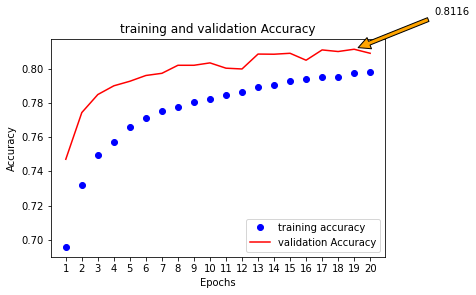

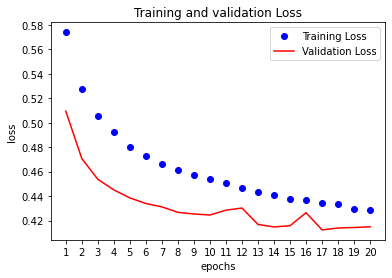

In [88]:
history = model_cleaner.history
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs , acc , 'bo', label= "training accuracy")
plt.plot(epochs , val_acc , 'r' , label ="validation Accuracy")
plt.title("training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) +1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext = (x_arrow +5 , y_arrow +.02),
             arrowprops = dict(facecolor = 'orange',shrink = 0.05))
plt.xticks(epochs)
plt.figure()
plt.plot(epochs, loss , 'bo' , label = 'Training Loss')
plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
plt.title("Training and validation Loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.xticks(epochs)
plt.show()


wow,now that's a considerable performance gain! The model managed to reach an impressive 81.1% validation accuracy on the 18 epoch!

This goes to prove the following: The model is as good as the data



# 5.6 Predicting on custom Data

Now let's have some fu testing our new add all-pwerful model on some custom data!
This model will return values between 0 and 1, representing it's confidence on whether a teet holds a negative or a positive sentiment. The closer the value is to 0, the more confident the model is that this tweet is negative. The closer the value is to 1, the more confident the model is that this tweet is negative

In [93]:
def sentence_to_indices(sentence_words , max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j , w in enumerate(sentence_words):
        try:
            index = words_to_index[w]
        except:
            w = cleaned(w)
            try:
                index = words_to_index[w]
            except:
                index = words_to_index['unk']
        X[j] = index
    return X
def predict_custome_tweet_sentiment(custom_tweet):
    # Convert the tweet such that it can be fed to the model
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)),max_len)
    return model_cleaner.predict(np.array([x_input])).item()
            

In [94]:
predict_custome_tweet_sentiment("I'm happy you're here!")

0.9981591701507568

In [96]:
predict_custome_tweet_sentiment("I'm not happy you're here! ")

0.3177010715007782

In [97]:
predict_custome_tweet_sentiment("I disliked his attitude")

0.22100090980529785

In [98]:
predict_custome_tweet_sentiment("i love you")

0.8638983964920044

In [99]:
predict_custome_tweet_sentiment("i dont love you")

0.2621074914932251

In [101]:
predict_custome_tweet_sentiment("I'm infatuated with you")

0.2889869213104248

In [ ]:
pred =model_cleaner.predict(X_test)
c=0
for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0
    if(final_pred == Y_test[i]):
        c+=1
print("Accuracy is:{}%".format((c/len(Y_test)*100)))        